In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}  # string to index
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}  # index to string
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [73]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [74]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [149]:
# build the dataset
# block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words): 
  block_size = 3 
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [14]:
C = torch.randn((27, 2))

In [22]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [23]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [39]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [40]:
h

tensor([[ 0.7099,  0.9838, -0.3356,  ...,  0.6989, -0.2240,  0.7776],
        [ 0.7312,  0.9726, -0.2622,  ...,  0.6982, -0.1955,  0.6541],
        [ 0.9186,  0.9710, -0.5557,  ...,  0.7388, -0.9574, -0.2940],
        ...,
        [ 0.8173,  0.9679, -0.1264,  ..., -0.9753,  0.2237, -0.9473],
        [ 0.5163,  0.9999,  0.8576,  ...,  0.7439,  0.9390,  0.9988],
        [-0.0215,  0.9986, -0.6432,  ..., -0.9658, -0.1580,  0.3888]])

In [41]:
h.shape

torch.Size([32, 100])

In [42]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [43]:
logits = h @ W2 + b2

In [44]:
logits.shape

torch.Size([32, 27])

In [46]:
counts = logits.exp()

In [47]:
prob = counts / counts.sum(1, keepdims=True)

In [48]:
prob.shape

torch.Size([32, 27])

In [52]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(13.2154)

In [150]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [216]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [217]:
sum(p.nelement() for p in parameters)

11897

In [218]:
for p in parameters:
    p.requires_grad = True

In [219]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [220]:
lri = []
lossi = []
stepi = []

In [221]:
for i in range(200000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
    stepi.append(i)
    lossi.append(loss.log10().item())

# print(loss.item())

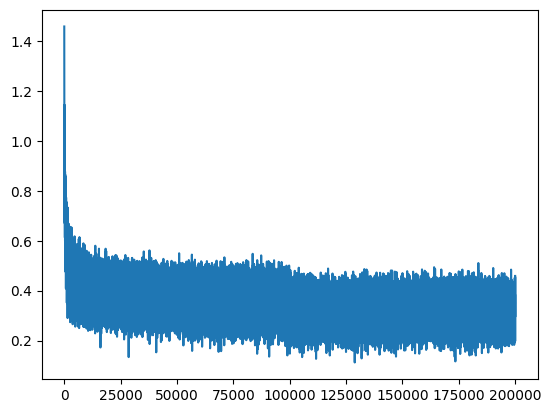

In [222]:
plt.plot(stepi, lossi)

In [223]:
print(loss.item())

2.876016616821289


In [224]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1617, grad_fn=<NllLossBackward0>)

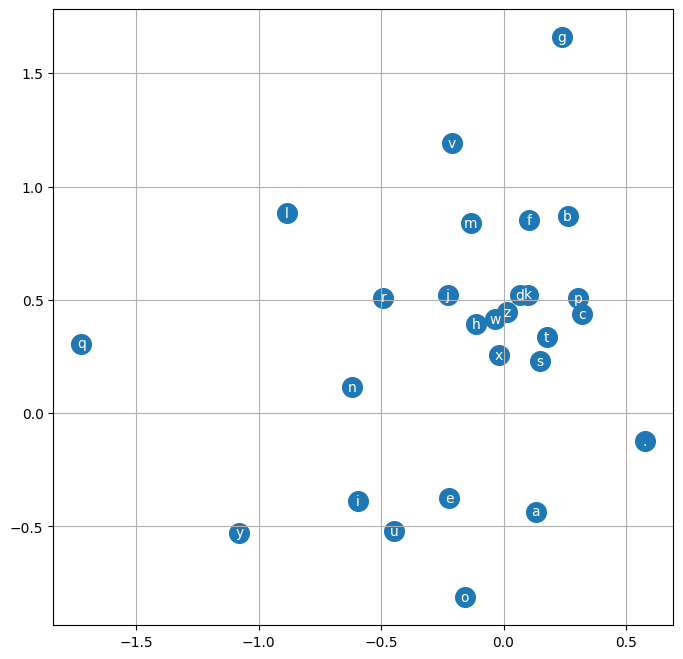

In [196]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [ ]:
# training split, validation split, test split
# 80%, 10%, 10%

In [225]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahzabelle.
khywarli.
thiyah.
cassie.
mahube.
delynn.
jareei.
nellara.
chaiir.
kaleigh.
ham.
jorniquint.
shon.
wan.
addi.
wajerma.
jarynix.
kaeliigsabee.
deci.
abetteley.
